<a href="https://colab.research.google.com/github/blkeyd/CVPR/blob/main/Final/Paper/E_AlexNet_FireDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [13]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

Mount Drive

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Device

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Dataset Path

In [16]:
data_dir = "/content/drive/MyDrive/fire_dataset_split"

Image Transformations

In [17]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Load Datasets

In [18]:
train_data = datasets.ImageFolder(data_dir + "/train", transform=transform)
val_data   = datasets.ImageFolder(data_dir + "/val", transform=transform)
test_data  = datasets.ImageFolder(data_dir + "/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes
print("Classes:", class_names)
print("Train:", len(train_data))
print("Val:", len(val_data))
print("Test:", len(test_data))

Classes: ['fire', 'nofire']
Train: 866
Val: 250
Test: 238


SE (Squeeze and Excitation) attention block

In [19]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

Enhanced AlexNet Architecture

In [20]:
class EnhancedAlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedAlexNet, self).__init__()

        self.features = nn.Sequential(
            # Conv1
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Conv2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Conv3
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.1),

            # Attention block
            SEBlock(384),

            # Conv4
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),

            # Conv5
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.LeakyReLU(0.1),

            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(0.1),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Initialize Model

In [21]:
model = EnhancedAlexNet(num_classes=2).to(device)
print(model)

# 10. Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

EnhancedAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): SEBlock(
      (fc1): Linear(in_features=384, out_features=24, bias=True)
      (fc2): Linear(in_features=24, out_features=384, bias=True)
    )
    (12): Conv2d(3

Training Function

In [22]:
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss/len(train_loader):.4f} "
              f"Train Acc: {train_acc:.2f}% "
              f"Val Acc: {val_acc:.2f}%")

Evaluatoin Function

In [23]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)

    print("\nClassification Report:\n",
          classification_report(all_labels, all_preds, target_names=class_names))

Run Training

In [12]:
train_model(model, train_loader, val_loader, epochs=10)

Epoch [1/10] Train Loss: 0.2702 Train Acc: 90.99% Val Acc: 94.00%
Epoch [2/10] Train Loss: 0.1065 Train Acc: 95.73% Val Acc: 96.40%
Epoch [3/10] Train Loss: 0.0746 Train Acc: 97.23% Val Acc: 97.20%
Epoch [4/10] Train Loss: 0.1017 Train Acc: 96.30% Val Acc: 96.40%
Epoch [5/10] Train Loss: 0.2539 Train Acc: 97.00% Val Acc: 97.20%
Epoch [6/10] Train Loss: 0.1482 Train Acc: 94.57% Val Acc: 95.60%
Epoch [7/10] Train Loss: 0.1006 Train Acc: 95.84% Val Acc: 96.80%
Epoch [8/10] Train Loss: 0.0816 Train Acc: 96.19% Val Acc: 96.80%
Epoch [9/10] Train Loss: 0.0550 Train Acc: 97.92% Val Acc: 96.80%
Epoch [10/10] Train Loss: 0.0450 Train Acc: 97.92% Val Acc: 97.20%


Final Evauation on Test Set

In [24]:
evaluate_model(model, test_loader)

Confusion Matrix:
 [[  0 200]
 [  0  38]]

Classification Report:
               precision    recall  f1-score   support

        fire       0.00      0.00      0.00       200
      nofire       0.16      1.00      0.28        38

    accuracy                           0.16       238
   macro avg       0.08      0.50      0.14       238
weighted avg       0.03      0.16      0.04       238



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix

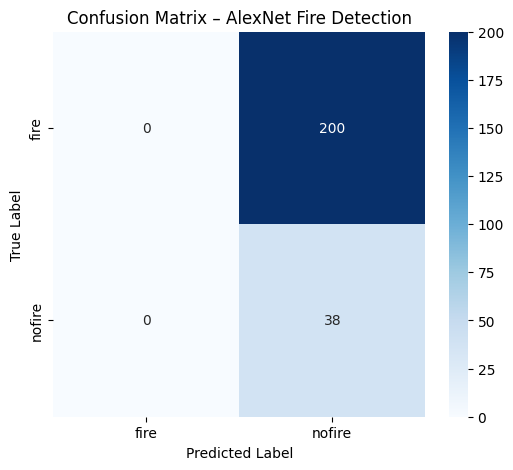

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=class_names,
                yticklabels=class_names,
                cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix – AlexNet Fire Detection")
    plt.show()

plot_confusion_matrix(model, test_loader)

ROC Curve

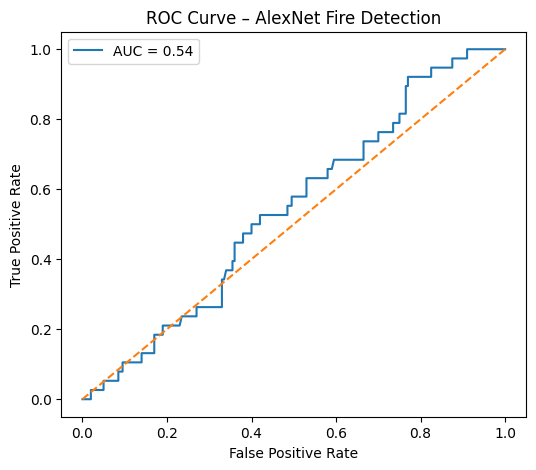

In [29]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, test_loader):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs[:, 1].cpu().numpy())  # probability of "fire"
            all_labels.extend(labels.cpu().numpy())

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve – AlexNet Fire Detection")
    plt.legend()
    plt.show()

plot_roc_curve(model, test_loader)

Saving the Model

In [27]:
torch.save(model.state_dict(), "/content/drive/MyDrive/enhanced_alexnet_fire_model.pth")
print("Model saved successfully.")

Model saved successfully.
